In [769]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize
from IPython.display import display, Math

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [770]:
import numpy as np
from numpy.random import normal
from scipy.special import erfc
from  scipy.constants import c, h
from scipy import constants
import matplotlib.pyplot as plt
from dsp import firFilter, pulseShape, eyediagram, lowPassFIR
from commpy.utilities  import signal_power, upsample
from models import mzm

In [771]:
SMALL_SIZE = 14
MEDIUM_SIZE = 14
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [772]:
def edfa_lin(signal, gain, nf, fc, fs):
    nf_lin   = 10**(nf/10)
    gain_lin = 10**(gain/10)
    nsp      = (gain_lin*nf_lin - 1)/(2*(gain_lin - 1))
    s_ase    = (gain_lin - 1) * nsp * h * fc
    p_noise  = s_ase * fs
    mean_noise = 0
    noise    = np.random.normal(mean_noise, np.sqrt(p_noise), signal.shape) + 1j*np.random.normal(mean_noise, np.sqrt(p_noise), signal.shape)
    return signal*gain_lin + noise

In [773]:
def SSF_symmetric(E, hz, Lspan, alpha, gamma, D, Fc, Fs):
    λ  = c/Fc
    α  = 1e-3*alpha/(10*np.log10(np.exp(1)))
    β2 = -(D*λ**2)/(2*np.pi*c)
            
    Nfft = len(E)

    ω = 2*np.pi*Fs*np.fft.fftfreq(Nfft)
    z = 0
    n = int(Lspan/hz); #número de passos hz dentro de Lspan
    dhz = Lspan-n*hz #sobra de um passo hz
   
    E = np.fft.fft(E)
    # Primeiro passo - operador linear
    E = E*np.exp(-α*(dhz/2)+1j*(β2/2)*(ω**2)*(dhz/2))

    # Operador não linear
    E = np.fft.ifft(E)            
    E = E*np.exp(1j*gamma*(np.abs(E)**2)*dhz)
        
    # Segundo passo - operador linear
    E = np.fft.fft(E)
    E = E*np.exp(-α*(dhz/2)+1j*(β2/2)*(ω**2)*(dhz/2))
        
    z = z+dhz
    
    while z < Lspan:
        # Primeiro passo - operador linear
        E = E*np.exp(-α*(hz/2)+1j*(β2/2)*(ω**2)*(hz/2))

        # Operador não linear
        E = np.fft.ifft(E)            
        E = E*np.exp(1j*gamma*(np.abs(E)**2)*hz)
        
        # Segundo passo - operador linear
        E = np.fft.fft(E)
        E = E*np.exp(-α*(hz/2)+1j*(β2/2)*(ω**2)*(hz/2))
        
        z = z + hz
        
    E = np.fft.ifft(E)
    return E,z

# Transmissão 10G OOK - 240 km

In [774]:
# parâmetros da simulação
SpS = 16
Rs  = 10e9          # Taxa de símbolos (para o caso do OOK Rs = Rb)
Ts  = 1/Rs          # Período de símbolo em segundos
Fa  = 1/(Ts/SpS)    # Frequência de amostragem do sinal (amostras/segundo)
Ta  = 1/Fa          # Período de amostragem
Fs  = 64e9          # Hz

kB  = constants.value('Boltzmann constant')
q  = constants.value('elementary charge') # carga elementar do elétron


In [775]:
# Parâmetros do sinal
lmbd   = 1550e-9       # comprimento de onda central (m)
Fc = c/lmbd            # frequência central (Hz)

caso = "caso3"   #caso1, caso2 ou caso3
# potência de sinal óptico na entrada do modulador em dBm
if(caso == "caso1"):
    Pi_dBm = -20
if(caso == "caso2"):
    Pi_dBm = 18.4 
if(caso == "caso3"):
    Pi_dBm = 6.4 

In [776]:
# Parâmetros do MZM
Vπ = 2
Vb = -Vπ/2
Pi = 10**(Pi_dBm/10)*1e-3 # potência de sinal óptico em W na entrada do MZM

In [777]:
# Parâmetros da fibra
alpha = 0.16   # dB/Km
D     = 18e-6  # Parâmetro de dispersão s/(m*m) - SMF28 (ps/(nm*km))
Dc    = -630e-6   #DCF
gamma = 1.3e-3 # W-1/m
Lspan = 240e3   # Comprimento do enlace m
hz    = 1e3  # m

In [778]:
# Parâmetros do receptor
Rd  = 0.85      # responsividade em A/W
Id  = 100e-9   # corrente de escuro em nA
B   = 10e9     # banda do receptor em Hz
RL  = 50           # RL em Ohms
Tc  = 25        # temperatura em Celsius

In [779]:
# gera sequência de bits pseudo-aleatórios
bitsTx   = np.random.randint(2, size=10000)    
n      = np.arange(0, bitsTx.size)

# mapeia bits para pulsos elétricos
symbTx = 2*bitsTx-1
symbTx = symbTx/np.sqrt(signal_power(symbTx))

# upsampling
symbolsUp = upsample(symbTx, SpS)

# pulso NRZ típico
pulse = pulseShape('nrz', SpS)
pulse = pulse/max(abs(pulse))

# plota sinal 
t = np.arange(0, symbTx.size)*(Ta/1e-9)

idX = np.arange(0,513)
#idX = np.arange(0,1023)


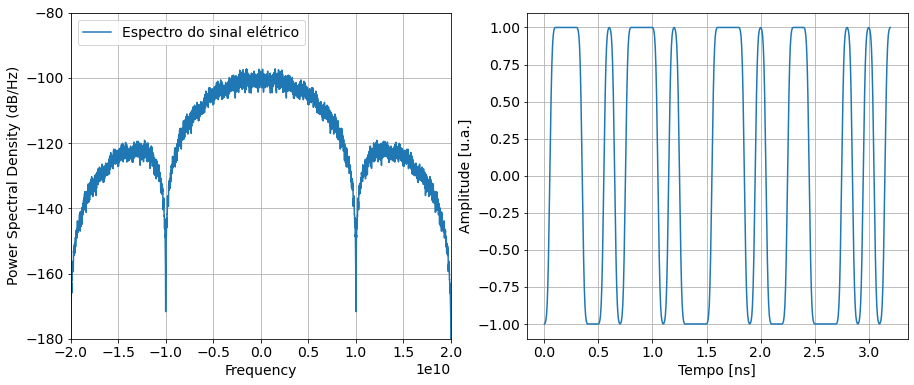

In [780]:
# formatação de pulso
sigTx  = firFilter(pulse, symbolsUp)

# plota psd
fig, axs = plt.subplots(1, 2, figsize=(15,6))
axs[0].set_xlim(-2*Rs,2*Rs);
axs[0].set_ylim(-180,-80);
axs[0].psd(sigTx,Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal elétrico')
axs[0].legend(loc='upper left')

axs[1].plot(t[idX], sigTx[idX].real)
axs[1].set_xlabel('Tempo [ns]')
axs[1].set_ylabel('Amplitude [u.a.]')
axs[1].grid(True)
plt.show()

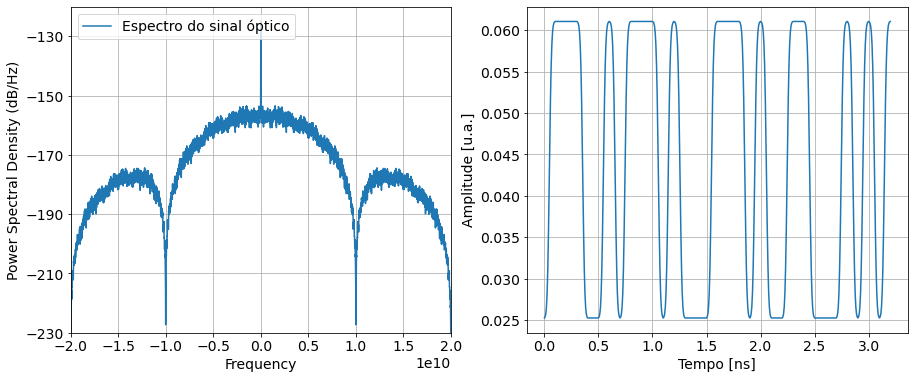

In [781]:
# modulação óptica
Ai     = np.sqrt(Pi)
sigTxo = mzm(Ai, Vπ, 0.5*sigTx, Vb)

# plota psd
fig, axs = plt.subplots(1, 2, figsize=(15,6))
axs[0].set_xlim(-2*Rs,2*Rs);
axs[0].set_ylim(-230,-120);
axs[0].psd(np.abs(sigTxo)**2,Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal óptico')
axs[0].legend(loc='upper left')

axs[1].plot(t[idX], np.abs(sigTxo[idX]))
axs[1].set_xlabel('Tempo [ns]')
axs[1].set_ylabel('Amplitude [u.a.]')
axs[1].grid(True)
plt.show()

In [782]:
### transmissão óptica
NFFT = len(sigTxo)
sigTxoFFT = np.fft.fftshift(np.fft.fft(sigTxo))/NFFT
sigTxoPx  = np.abs(sigTxoFFT)**2

# Percurso óptico

freq = np.fft.fftfreq(len(sigTxo),1/Fs)
alpha_lin = 1e-3*alpha/(10*np.log10(np.exp(1)))
beta2 = -(D*lmbd**2)/(2*np.pi*c)
betac = -(Dc*lmbd**2)/(2*np.pi*c)

if (caso == "caso1"):
    E = sigTxo
    
    #amplificação edfa total - booster
    E    = edfa_lin(E, 1e-3*alpha*Lspan, 12, Fc, Fa) 
 
    #propagação em de E em um percurso de comprimento Lspan
    E, z = SSF_symmetric(E, hz, Lspan, alpha, gamma, D, Fc, Fs)    

    #compensação da dispersãoo cromática
    zc=0;
    if betac != 0 :
        zc = -z*beta2/betac;
    Hc = np.exp(1j*0.5*betac*zc*(2*np.pi*freq)**2)
    E    = np.fft.ifft(np.fft.fft(E)*Hc) #compensação de dispersão
    
    sigRxo = E
    
if (caso == "caso2"):
    E = sigTxo
    
    #propagação em de E em um percurso de comprimento Lspan
    E, z = SSF_symmetric(E, hz, Lspan, alpha, gamma, D, Fc, Fs)    

    #amplificação com EDFA - preamplifier
    E    = edfa_lin(E, 1e-3*alpha*Lspan, 8, Fc, Fa)

    #compensação da dispersãoo cromática
    zc=0;
    if betac != 0 :
        zc = -z*beta2/betac;
    Hc = np.exp(1j*0.5*betac*zc*(2*np.pi*freq)**2)
    E    = np.fft.ifft(np.fft.fft(E)*Hc) #compensação de dispersão

    sigRxo = E
    
if (caso == "caso3"): 
    Nspan = 4;
    E = sigTxo
    #E    = edfa_lin(E, 1e-3*alpha*Lspan, 12, Fc, Fa) #amplificação edfa total - booster
    for i in range(Nspan):
        #propagação em de E em um percurso de comprimento Lspan/Nspan
        E, z = SSF_symmetric(E, hz, Lspan/Nspan, alpha, gamma, D, Fc, Fs)    

        #amplificação com EDFA
        E    = edfa_lin(E, 1e-3*alpha*z, 9, Fc, Fa)

        #compensação da dispersãoo cromática
        zc=0;
        if betac != 0 :
            zc = -z*beta2/betac;
        Hc = np.exp(1j*0.5*betac*zc*(2*np.pi*freq)**2)
        E    = np.fft.ifft(np.fft.fft(E)*Hc) #compensação de dispersão

    #E    = edfa_lin(E, 1e-3*alpha*Lspan, 8, Fc, Fa) #amplificação edfa total - preamplifier
    sigRxo = E

freq = np.fft.fftshift(np.fft.fftfreq(len(sigTxoFFT), Ta))
sigRxoFFT = np.fft.fftshift(np.fft.fft(sigRxo))/NFFT
sigRxoPx  = np.abs(sigRxoFFT)**2

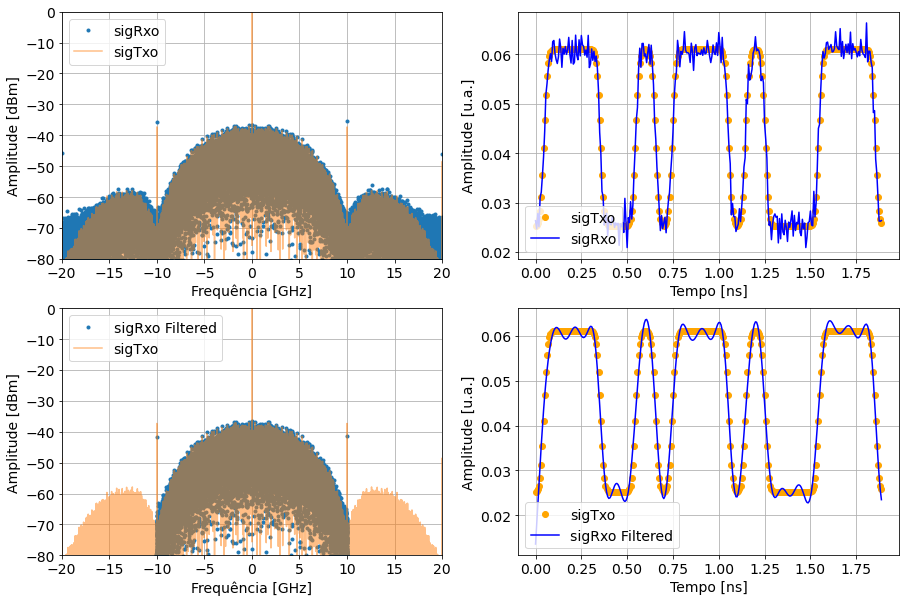

Potência do sinal Tx (em dBm) = 3.38 dBm
Potência do sinal Rx (em dBm) = 3.39 dBm


In [783]:
fig, axs = plt.subplots(2, 2, figsize=(15,10))
axs[0,0].plot(1e-9*freq, 10*np.log10(1e3*sigRxoPx), '.', label = 'sigRxo')
axs[0,0].plot(1e-9*freq, 10*np.log10(1e3*sigTxoPx), alpha = 0.5, label = 'sigTxo')
axs[0,0].set_ylabel('Amplitude [dBm]')
axs[0,0].set_xlabel('Frequência [GHz]')
axs[0,0].set_xlim(-2e-9*Rs,2e-9*Rs)
axs[0,0].set_ylim(-80,0)
axs[0,0].grid(True)
axs[0,0].legend(loc = 'upper left')

axs[0,1].plot(t[0:303], np.abs(sigTxo[0:303]), 'o',color = "orange", label = 'sigTxo')
axs[0,1].plot(t[0:303], np.abs(sigRxo[0:303]), color = "blue", label = 'sigRxo')
axs[0,1].set_xlabel('Tempo [ns]')
axs[0,1].set_ylabel('Amplitude [u.a.]')
axs[0,1].grid(True)
axs[0,1].legend(loc = 'lower left')


N = 8001
h_filter = lowPassFIR(B, Fa, N, typeF='rect')
sigRxo_filtered = firFilter(h_filter, sigRxo)
sigRxo_filtered_FFT = np.fft.fftshift(np.fft.fft(sigRxo_filtered))/NFFT
sigRxo_filtered_Px  = np.abs(sigRxo_filtered_FFT)**2

axs[1,0].plot(1e-9*freq, 10*np.log10(1e3*sigRxo_filtered_Px), '.', label = 'sigRxo Filtered')
axs[1,0].plot(1e-9*freq, 10*np.log10(1e3*sigTxoPx), alpha = 0.5, label = 'sigTxo')
axs[1,0].set_ylabel('Amplitude [dBm]')
axs[1,0].set_xlabel('Frequência [GHz]')
axs[1,0].set_xlim(-2e-9*Rs,2e-9*Rs)
axs[1,0].set_ylim(-80,0)
axs[1,0].grid(True)
axs[1,0].legend(loc = 'upper left')

axs[1,1].plot(t[0:303], np.abs(sigTxo[0:303]), 'o',color = "orange", label = 'sigTxo')
axs[1,1].plot(t[0:303], np.abs(sigRxo_filtered[0:303]), color = "blue", label = 'sigRxo Filtered')
axs[1,1].set_xlabel('Tempo [ns]')
axs[1,1].set_ylabel('Amplitude [u.a.]')
axs[1,1].grid(True)
axs[1,1].legend(loc = 'lower left')
plt.show()

print('Potência do sinal Tx (em dBm) = %.2f dBm' %(10*np.log10(np.sum(sigTxoPx)/1e-3)))
print('Potência do sinal Rx (em dBm) = %.2f dBm' %(10*np.log10(np.sum(sigRxoPx)/1e-3)))


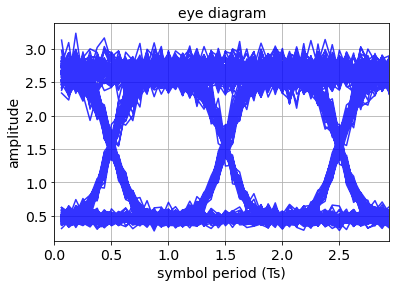

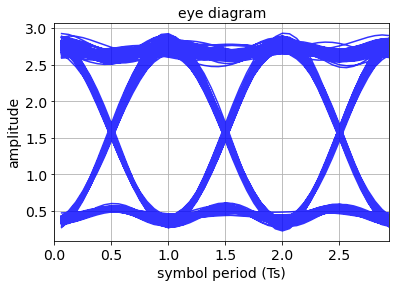

Pin[Rx] = 3.39 dBm 
I0 = 0.36  
I1 = 2.78  
σ0 = 0.05  
σ1 = 0.07  
Limiar ótimo Id = 1.38  
Q = 21.39   

Total de erros contados = 0  
BER = 0.00e+00  
Pb = 8.87e-102  


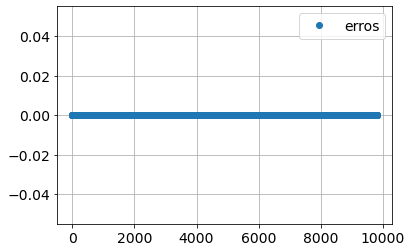

In [784]:

### Receptor
Pin = (np.abs(sigRxo)**2).mean() # Potência óptica média média recebida

# fotocorrente livre de ruído
Ip = Rd*np.abs(sigRxo)**2

# ruído de disparo 
σ2_s = 2*q*(Rd*Pin + Id)*B  # variância  

# ruído térmico
T = Tc + 273.15     # temperatura em Kelvin
σ2_T = 4*kB*T*B/RL  # variância do ruído térmico

# adiciona ruído do receptor p-i-n aos sinais
Is   = normal(0, np.sqrt(Fa*(σ2_s/(2*B))), Ip.size)
It   = normal(0, np.sqrt(Fa*(σ2_T/(2*B))), Ip.size)  

I = Ip + Is + It

# filtragem Rx

N = 8001
h_filter = lowPassFIR(B, Fa, N, typeF='rect')

I_Rx  = firFilter(h_filter, I)
I_Rx = I_Rx/np.std(I_Rx)

# calculando a SNR na simulação
Ip_Rx  = firFilter(h_filter, Ip)
Is_Rx  = firFilter(h_filter, Is)
It_Rx  = firFilter(h_filter, It)


# gera sinal para visualizaçã do diagrama de olho
I_eye = I_Rx[100*SpS:I_Rx.size-100*SpS]

Nsamples = 10000
eyediagram(Ip/np.std(Ip),  Nsamples, SpS)
eyediagram(I_eye/np.std(I_eye), Nsamples, SpS)


print('Pin[Rx] = %.2f dBm '%(10*np.log10(Pin/1e-3)))


# captura amostras no meio dos intervalos de sinalização
I_Rx  = I_Rx[0::SpS]

# obtém estatísticas do sinal recebido

I1 = np.mean(I_Rx[bitsTx==1]) # valor médio de I1
I0 = np.mean(I_Rx[bitsTx==0]) # valor médio de I0

σ1 = np.std(I_Rx[bitsTx==1]) # desvio padrão σ1 de I1 
σ0 = np.std(I_Rx[bitsTx==0]) # desvio padrão σ0 de I0 

Id = (σ1*I0 + σ0*I1)/(σ1 + σ0) # limiar de decisão ótimo
Q  = (I1-I0)/(σ1 + σ0)         # fator Q

print('I0 = %.2f  '%(I0))
print('I1 = %.2f  '%(I1))
print('σ0 = %.2f  '%(σ0))
print('σ1 = %.2f  '%(σ1))
print('Limiar ótimo Id = %.2f  '%(Id))
print('Q = %.2f   \n'%(Q))

# Aplica a regra de decisão ótima
bitsRx = np.empty(bitsTx.size)
bitsRx[I_Rx>  Id] = 1
bitsRx[I_Rx<= Id] = 0

discard = 100
err = np.logical_xor(bitsRx[discard:bitsRx.size-discard], bitsTx[discard:bitsTx.size-discard])
BER = np.mean(err)

Pb = 0.5*erfc(Q/np.sqrt(2)) # probabilidade de erro teórica
print('Total de erros contados = %d  '%(err.sum()))
print('BER = %.2e  '%(BER))
print('Pb = %.2e  '%(Pb))

plt.plot(err,'o', label = 'erros')
plt.legend()
plt.grid()